In [55]:
import numpy as np
from time import time
import os
import sys
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.linalg import toeplitz
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import RidgeCV
from sklearn.cluster import KMeans
from skimage.filters import threshold_triangle

import bigbadbrain as bbb

In [68]:
dudi_fictrac = bbb.load_fictrac('C:/Users/User/Downloads', '170705_205.dat')


~~ load_fictrac ~~
load_fictrac done. Duration: 2.71 sec


In [12]:
fictracs = [dudi_fictrac]

In [18]:
3.175e-3*1000*100

317.5

Text(0.5,1,'Forward Velocity Histograms')

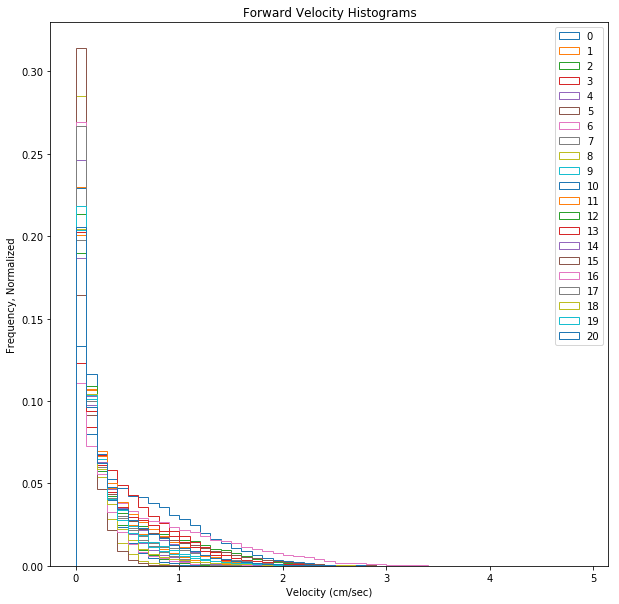

In [66]:
########################################
### Plot Forward Velocity Histograms ###
########################################

bins = np.ndarray.tolist(np.arange(0,5,.1))
fig = plt.figure(figsize=(10,10))
behavior = 'dRotLabY'
sphere_radius = 3.175e-3 #4.5e-3
binned_data = []
for i in range(len(fictracs)):
    vector = fictracs[i][behavior]*sphere_radius # now in m per 20ms
    vector = vector * 100 * 100 # multiply by Hz and cm/meter # now in cm per sec
    weights = np.ones_like(vector)/float(len(vector))
    binned,throwaway,throwaway2=plt.hist(vector,bins,weights=weights,label = str(i),stacked=True, histtype = 'step')
    binned_data.append(binned)
plt.legend()
#plt.xlim(.01,5)
plt.xlabel("Velocity (cm/sec)")
plt.ylabel("Frequency, Normalized")
plt.title("Forward Velocity Histograms")

Text(0.5,1,'Side-slip Velocity')

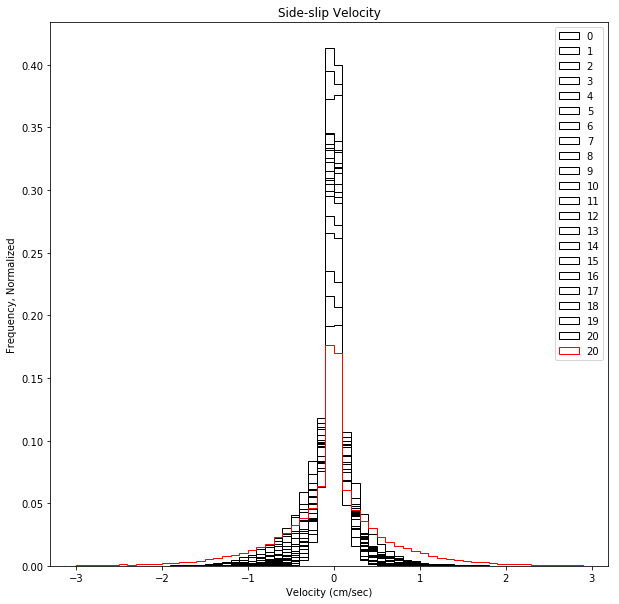

In [85]:
########################################
### Plot Angular Velocity Histograms ###
########################################

bins = np.ndarray.tolist(np.arange(-3,3,.1))
fig = plt.figure(figsize=(10,10))
behavior = 'dRotLabX'
sphere_radius = 4.5e-3 #3.175e-3 #
binned_data = []
for i in range(len(fictracs)):
    vector = fictracs[i][behavior]
    vector = vector * 100 * 50 * sphere_radius # now in deg per sec
    weights = np.ones_like(vector)/float(len(vector))
    binned,throwaway,throwaway2=plt.hist(vector,bins,weights=weights,label = str(i),stacked=True, histtype = 'step',color='k')
    binned_data.append(binned)

sphere_radius = 3.175e-3
behavior = 'dRotLabZ'
vector = dudi_fictrac[behavior]
vector = vector * 100 * 100 * sphere_radius # now in deg per sec
weights = np.ones_like(vector)/float(len(vector))
binned,throwaway,throwaway2=plt.hist(vector,bins,weights=weights,label = str(i),stacked=True, histtype = 'step',color='r')
binned_data.append(binned)    

plt.legend()
#plt.xlim(.01,5)
plt.xlabel("Velocity (cm/sec)")
plt.ylabel("Frequency, Normalized")
plt.title("Side-slip Velocity")

In [64]:
root_path = 'C:/Users/User/Downloads/drive-download-20190606T161949Z-001'
files = [os.path.join(root_path, file) for file in os.listdir(root_path)]

fictracs = []
for file in files:
    fictracs.append(load_fictrac2(file))

In [65]:
len(fictracs)

21

In [51]:
thing

'C:/Users/User/Downloads/drive-download-20190606T161949Z-001\\fictrac (1).dat'

In [60]:
def load_fictrac2(directory):
    """ Loads fictrac data from .dat file that fictrac outputs.

    To-do: change units based on diameter of ball etc.
    For speed sanity check, instead remove bad frames so we don't have to throw out whole trial.

    Parameters
    ----------
    directory: string of full path to file
    file: string of file name

    Returns
    -------
    fictrac_data: pandas dataframe of all parameters saved by fictrac """

    with open(directory,'r') as f:
        df = pd.DataFrame(l.rstrip().split() for l in f)

        # Name columns
        df = df.rename(index=str, columns={0: 'frameCounter',
                                       1: 'dRotCamX',
                                       2: 'dRotCamY',
                                       3: 'dRotCamZ',
                                       4: 'dRotScore',
                                       5: 'dRotLabX',
                                       6: 'dRotLabY',
                                       7: 'dRotLabZ',
                                       8: 'AbsRotCamX',
                                       9: 'AbsRotCamY',
                                       10: 'AbsRotCamZ',
                                       11: 'AbsRotLabX',
                                       12: 'AbsRotLabY',
                                       13: 'AbsRotLabZ',
                                       14: 'positionX',
                                       15: 'positionY',
                                       16: 'heading',
                                       17: 'runningDir',
                                       18: 'speed',
                                       19: 'integratedX',
                                       20: 'integratedY',
                                       21: 'timeStamp',
                                       22: 'sequence'})

        # Remove commas
        for column in df.columns.values[:-1]:
            df[column] = [float(x[:-1]) for x in df[column]]

        fictrac_data = df
                
    # sanity check for extremely high speed (fictrac failure)
    speed = np.asarray(fictrac_data['speed'])
    max_speed = np.max(speed)
    if max_speed > 10:
        raise Exception('Fictrac ball tracking failed (reporting impossibly high speed).')
    return fictrac_data